This notebook contains:
- Preprocess and examples of VQA-RAD dataset
- CLIP with linear fusion
- Fine-tune CLIP on VQA-RAD dataset (as a classification task)

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
from typing import Any, Optional, Tuple, Union
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from datasets import load_dataset, DatasetDict
from transformers import CLIPProcessor, CLIPModel, AutoModel, AutoTokenizer,  AutoImageProcessor, CLIPImageProcessor
from transformers import TrainingArguments, Trainer
from transformers.data import DataCollatorWithPadding
from transformers.modeling_outputs import ImageClassifierOutput

## Dataset

In [2]:
from datasets import load_dataset, DatasetDict
import matplotlib.pyplot as plt

In [3]:
dataset = load_dataset("flaviagiammarino/vqa-rad")
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

In [7]:
dataset['train'][0]

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=566x555>,
 'question': 'are regions of the brain infarcted?',
 'answer': 'yes'}

### Split train/valid/test

In [4]:
# train 1568 70%
# valid 225 10%
# test 451 20%
train_val_dataset = dataset["train"].train_test_split(test_size=0.125, seed=123)
train_val_test_dataset = DatasetDict({'train': train_val_dataset['train'],
                                      'val': train_val_dataset['test'],
                                      'test': dataset['test']})
                                      
train_val_test_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1568
    })
    val: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 225
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})

### Close-ended question subset

In [11]:
# original splits
print("# Close-ended question")
for split in dataset.keys():
    cnt = 0
    for i in range(len(dataset[split])):
        if dataset[split][i]['answer'].lower() in ("yes", "no"):
            cnt += 1
    print(f"{split}: {cnt} / {len(dataset[split])}")

# Close-ended question
train: 940 / 1793
test: 251 / 451


In [16]:
# train/val/test split
# train 821 69%
# val 119 10%
# test 251 21%
print("# Close-ended question")
for split in train_val_test_dataset.keys():
    cnt = 0
    for i in range(len(train_val_test_dataset[split])):
        if train_val_test_dataset[split][i]['answer'].lower() in ("yes", "no"):
            cnt += 1
    print(f"{split}: {cnt} / {len(train_val_test_dataset[split])}")

# Close-ended question
train: 821 / 1568
val: 119 / 225
test: 251 / 451


In [5]:
close_ended_dataset = dataset.filter(lambda example: example["answer"].lower() in ("yes", "no"))
close_ended_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 940
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 251
    })
})

In [6]:
close_ended_train_val_test_dataset = train_val_test_dataset.filter(lambda example: example["answer"].lower() in ("yes", "no"))
close_ended_train_val_test_dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 821
    })
    val: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 119
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 251
    })
})

is there evidence of large calcified lesions in the lung fields?
no


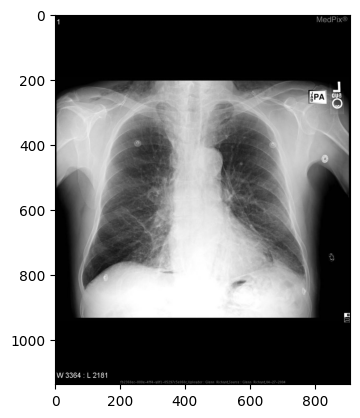

In [21]:
example = close_ended_train_val_test_dataset['train'][0]
print(example["question"])
print(example["answer"])
plt.imshow(example['image'])

### Preprocess
- Map answer to 0/1
- Tokenizer question (pad to tensors in data collator)

In [9]:
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
def preprocess(batch):
    batch["labels"] = [1 if answer.lower() == "yes" else 0 for answer in batch["answer"]]
    image_features = image_processor(batch["image"])
    text_features = tokenizer(batch["question"])
    batch = {**image_features, **text_features, **batch}
    return batch

In [122]:
image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
image_features = image_processor(dataset['train'][:4]['image'])
type(image_features['pixel_values'][0])

numpy.ndarray

In [108]:
text_features = tokenizer(text) # no padding
text_features

{'input_ids': [[49406, 631, 14530, 539, 518, 4812, 1529, 516, 2910, 286, 49407], [49406, 631, 518, 27366, 5967, 18759, 286, 49407], [49406, 1448, 13213, 2422, 533, 40934, 530, 589, 2867, 286, 49407], [49406, 533, 518, 534, 1015, 10779, 8735, 1195, 27030, 1223, 697, 656, 286, 49407]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

In [10]:
# image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
# tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
processed_dataset = close_ended_train_val_test_dataset.map(preprocess, batched=True)
processed_dataset = processed_dataset.remove_columns(["image", "question", "answer"])
processed_dataset

DatasetDict({
    train: Dataset({
        features: ['labels', 'pixel_values', 'input_ids', 'attention_mask'],
        num_rows: 821
    })
    val: Dataset({
        features: ['labels', 'pixel_values', 'input_ids', 'attention_mask'],
        num_rows: 119
    })
    test: Dataset({
        features: ['labels', 'pixel_values', 'input_ids', 'attention_mask'],
        num_rows: 251
    })
})

In [161]:
print(processed_dataset['train'][0]['labels'])
print(processed_dataset['train'][0]['input_ids'])
print(processed_dataset['train'][0]['attention_mask'])
print(np.array(processed_dataset['train'][0]['pixel_values']).shape) # list

0
[49406, 533, 997, 6439, 539, 3638, 22824, 2853, 534, 4060, 530, 518, 16271, 6494, 286, 49407]
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
(3, 224, 224)


### Data Collator

- tokenizer.pad: https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils_base.py#L3199
- tokenizer._pad: pad attention_mask, token_type_ids, special_tokens_mask, input_ids, and remain other items unchanged (collated in later functions)
https://github.com/huggingface/transformers/blob/main/src/transformers/tokenization_utils_base.py#L3672
- data collator with padding: https://github.com/huggingface/transformers/blob/v4.40.2/src/transformers/data/data_collator.py#L237

In [190]:
from transformers.data import DataCollatorWithPadding

In [178]:
batch = [processed_dataset['train'][i] for i in range(4)]
padded_batch = tokenizer.pad(batch, return_tensors="pt")
for k, v in padded_batch.items():
    print(k, v.shape)
i = 2
print("labels", batch[i]["labels"], padded_batch["labels"][i], sep="\n")
print("pixel values", np.all(np.array(batch[i]["pixel_values"]) == np.array(padded_batch["pixel_values"][i]))) # unchanged!
print("input_ids", batch[i]["input_ids"], padded_batch["input_ids"][i], sep="\n")
print("attention_mask", batch[i]["attention_mask"], padded_batch["attention_mask"][i], sep="\n")
# can use DataCollatorWithPadding (provide tokenizer to the hugginface trainer)

labels torch.Size([4])
pixel_values torch.Size([4, 3, 224, 224])
input_ids torch.Size([4, 16])
attention_mask torch.Size([4, 16])
labels
1
tensor(1)
pixel values True
input_ids
[49406, 631, 518, 29050, 8258, 18417, 2494, 286, 49407]
tensor([49406,   631,   518, 29050,  8258, 18417,  2494,   286, 49407, 49407,
        49407, 49407, 49407, 49407, 49407, 49407])
attention_mask
[1, 1, 1, 1, 1, 1, 1, 1, 1]
tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])


## CLIP

In [104]:
import torch
from transformers import CLIPProcessor, CLIPModel, AutoTokenizer,  AutoImageProcessor, CLIPImageProcessor

In [32]:
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

### Zero-Shot Image Classification

In [17]:
image = dataset['train'][0]['image']

inputs = processor(text=["yes", "no"], images=image, return_tensors="pt", padding=True)

with torch.no_grad():
    outputs = model(**inputs)
logits_per_image = outputs.logits_per_image # this is the image-text similarity score
probs = logits_per_image.softmax(dim=1) # we can take the softmax to get the label probabilities

print("Ground truth:", dataset['train'][0]['answer'])
print("Predicted probs:", probs)

Ground truth: yes
Predicted probs: tensor([[0.3213, 0.6787]])


### CLIP modules

In [29]:
image = dataset['train'][0]['image']
image_inputs = processor(images=image, return_tensors="pt")
image_inputs['pixel_values'].shape

torch.Size([1, 3, 224, 224])

In [36]:
text = dataset['train'][0]['question']
text_inputs = tokenizer([text], padding=True, return_tensors="pt")
print(text_inputs)
print(text_inputs['input_ids'].shape)

{'input_ids': tensor([[49406,   631, 14530,   539,   518,  4812,  1529,   516,  2910,   286,
         49407]]), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])}
torch.Size([1, 11])


In [37]:
with torch.no_grad():
    text_features = model.get_text_features(**text_inputs)
    image_features = model.get_image_features(**image_inputs)
text_features.shape, image_features.shape

(torch.Size([1, 512]), torch.Size([1, 512]))

In [39]:
with torch.no_grad():
    text_outputs = model.text_model(**text_inputs)
for k, v in text_outputs.items():
    print(k, v.shape)
# apply text_project on pooler_output to get text_features

last_hidden_state torch.Size([1, 11, 512])
pooler_output torch.Size([1, 512])


In [40]:
# model

### Linear Fusion

- CLIP for image classfication: refer to how they define loss and output
https://github.com/huggingface/transformers/blob/main/src/transformers/models/clip/modeling_clip.py#L1327

In [3]:
from typing import Any, Optional, Tuple, Union

import torch
import torch.nn as nn
from transformers import AutoModel, AutoProcessor, AutoTokenizer
from transformers.modeling_outputs import ImageClassifierOutput

In [9]:
class CLIPwithLinearFusion(nn.Module):
    """
        Apply a fully connected network on concatenated text and image features
        Predict a scalar score for binary/multi-class classification
    """
    def __init__(self, clip_model_name, num_labels):
        super().__init__()
        self.base_model = AutoModel.from_pretrained(clip_model_name)
        self.num_labels = num_labels
        projection_dim = self.base_model.projection_dim
        output_dim = 1 if num_labels == 2 else num_labels # scalar output for binary classification
        self.MLP = nn.Sequential(nn.Linear(2 * projection_dim, 512),
                                 nn.ReLU(),
                                 nn.Linear(512, 128),
                                 nn.ReLU(),
                                 nn.Linear(128, output_dim))
    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        pixel_values: Optional[torch.FloatTensor] = None,
        attention_mask: Optional[torch.Tensor] = None,
        position_ids: Optional[torch.LongTensor] = None,
        labels: Optional[torch.Tensor] = None,
    ) -> torch.FloatTensor:
        
        text_features = self.base_model.get_text_features(input_ids=input_ids,
                                                          attention_mask=attention_mask,
                                                          position_ids=position_ids) # (N, 512)
        image_features = self.base_model.get_image_features(pixel_values=pixel_values) # (N, 512)
        concat_features = torch.cat([text_features, image_features], dim=1) # (N, 1024)
        logits = self.MLP(concat_features).squeeze() # (N,) or (N, C)
        
        loss = None
        if labels is not None:
            labels = labels.to(logits.device)
            if self.num_labels == 2:
                # binary classification
                loss_fct = nn.BCEWithLogitsLoss()
                loss = loss_fct(logits.squeeze(), labels.squeeze().float())
            else:
                # multi-class classification
                loss_fct = nn.CrossEntropyLoss()
                loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
            
        return ImageClassifierOutput(
            loss=loss,
            logits=logits,
        )

In [187]:
image = dataset['train'][:4]['image']
# image_inputs = processor(images=image, return_tensors="pt").to(device)
text = dataset['train'][:4]['question']
# text_inputs = tokenizer(text, padding=True, return_tensors="pt").to(device)
batch = processor(images=image, text=text, padding=True, return_tensors="pt").to(device)
model = CLIPwithLinearFusion("openai/clip-vit-base-patch32", 2).to(device)
with torch.no_grad():
    outputs = model(**batch)
print(outputs.loss)
print(outputs.logits)

None
tensor([-0.0277, -0.0502, -0.0423, -0.0046], device='cuda:0')


In [14]:
from transformers.data import DataCollatorWithPadding

tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")
data_collator = DataCollatorWithPadding(tokenizer)
batch = data_collator(processed_dataset['train'][:4])
batch = batch.to(device)

model = CLIPwithLinearFusion("openai/clip-vit-base-patch32", 2).to(device)
with torch.no_grad():
    outputs = model(**batch)
print(outputs.loss)
print(outputs.logits)

torch.float32 torch.int64
tensor(0.6756, device='cuda:0')
tensor([0.1057, 0.0790, 0.0893, 0.0859], device='cuda:0')


## Trainer

- Calculate loss in the custom model.
- Define compute_metric function.

In [5]:
from transformers import TrainingArguments, Trainer

In [12]:
def compute_accuracy(eval_pred):
    logits = eval_pred.predictions # ndarray
    labels = eval_pred.label_ids # ndarray
    if len(logits.shape) == 1:
        # binary classification
        predictions = logits > 0.5
    else:
        # multi class classification
        predictions = torch.argmax(logits, dim=1)
    accuracy = (predictions == labels).mean()

    return {"accuracy": accuracy}

In [218]:
from types import SimpleNamespace  

# binary
logits = torch.FloatTensor([0.1, 0.1, 0.6, 0.7, 0.9])
labels = torch.LongTensor([0, 1, 1, 0, 0])
eval_pred = SimpleNamespace(predictions=logits, label_ids=labels)

print(compute_accuracy(eval_pred))

# multi class
logits = torch.FloatTensor([[1.0, 0.1, 0.6],
                            [0.1, 1.0, -0.2],
                            [1.0, -0.2, -0.3]])
labels = torch.LongTensor([0, 1, 2])
eval_pred = SimpleNamespace(predictions=logits, label_ids=labels)

print(compute_accuracy(eval_pred))

{'accuracy': tensor(0.4000)}
{'accuracy': tensor(0.6667)}


In [10]:
dataset = load_dataset("flaviagiammarino/vqa-rad")
train_val_dataset = dataset["train"].train_test_split(test_size=0.125, seed=123)
train_val_test_dataset = DatasetDict({'train': train_val_dataset['train'],
                                      'val': train_val_dataset['test'],
                                      'test': dataset['test']})
close_ended_train_val_test_dataset = train_val_test_dataset.filter(lambda example: example["answer"].lower() in ("yes", "no"))

model = CLIPwithLinearFusion("openai/clip-vit-base-patch32", 2).to(device)

def preprocess(batch):
    batch["labels"] = [1 if answer.lower() == "yes" else 0 for answer in batch["answer"]]
    image_features = image_processor(batch["image"])
    text_features = tokenizer(batch["question"])
    batch = {**image_features, **text_features, **batch}
    return batch

image_processor = CLIPImageProcessor.from_pretrained("openai/clip-vit-base-patch32")
tokenizer = AutoTokenizer.from_pretrained("openai/clip-vit-base-patch32")

processed_dataset = close_ended_train_val_test_dataset.map(preprocess, batched=True)
processed_dataset = processed_dataset.remove_columns(["image", "question", "answer"])

/deep/u/ying1029/anaconda3/envs/cs231n/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [ ]:
for i in range(10):
    print(close_ended_train_val_test_dataset["train"][i]["question"])

In [8]:
torch.__version__ # require torch version >= 2.0.0

'2.0.1'

In [13]:
training_args = TrainingArguments(output_dir="clip-vit-base-patch32_linear_binary",
                                  evaluation_strategy="steps",
                                  per_device_train_batch_size=8,
                                  per_device_eval_batch_size=8,
                                  learning_rate=5e-6,
                                  num_train_epochs=3,
                                  logging_steps=10)
                                  # save_strategy="epoch",
                                  # load_best_model_at_end=True,)
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=processed_dataset["train"],
    eval_dataset=processed_dataset["val"],
    tokenizer=tokenizer,
    compute_metrics=compute_accuracy,
)

trainer.train()

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Step,Training Loss,Validation Loss,Accuracy
10,0.672600,0.693460,0.462185
20,0.688000,0.686667,0.462185
30,0.676800,0.683011,0.462185
40,0.683400,0.678259,0.462185
50,0.688800,0.680413,0.462185
60,0.659300,0.675306,0.462185
70,0.678800,0.673619,0.462185
80,0.654100,0.671307,0.462185
90,0.668300,0.674356,0.462185
100,0.674300,0.665351,0.462185


TrainOutput(global_step=309, training_loss=0.6072785784897295, metrics={'train_runtime': 876.4459, 'train_samples_per_second': 2.81, 'train_steps_per_second': 0.353, 'total_flos': 0.0, 'train_loss': 0.6072785784897295, 'epoch': 3.0})

In [18]:
!kill 3010288

In [24]:
# Load the TensorBoard notebook extension
%load_ext tensorboard
%tensorboard --logdir clip-vit-base-patch32_linear_binary/runs --bind_all

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
